<a href="https://colab.research.google.com/github/viraj-cz/predictive-coding/blob/main/PredictiveCoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Implementation and experiments with pred code networks

General Introduction to Predictive coding: https://arxiv.org/pdf/2107.12979.pdf

implementation of the predictive coding network in numpy ("An Approximation of the Error Backpropagation
Algorithm in a Predictive Coding Network
with Local Hebbian Synaptic Plasticity")

paper link: https://www.mrcbndu.ox.ac.uk/sites/default/files/pdf_files/Whittington%20Bogacz%202017_Neural%20Comput.pdf

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
'''
for test we want to return this:

  Weights (5x2 matrix) at run 4:
    0.5828   -0.7452
    0.7514   -0.4101
   -0.6907    0.0868
    0.7654    0.8471
    0.2451    0.8608

Weights at run 4:
    {5x2 double                            }
    {[-0.6848 0.9412 0.9143 -0.0292 0.6006]}
    {0x0 double                            }

Biases at run 4:
    {5x1 double}
    {[       0]}
    {0x0 double}
'''
def w_init_tanh_trial():
    # Fixed weights
    w = [
        np.array([[0.5828, -0.7452],
                  [0.7514, -0.4101],
                  [-0.6907, 0.0868],
                  [0.7654, 0.8471],
                  [0.2451, 0.8608]]),  # 5x2 matrix
        np.array([[-0.6848, 0.9412, 0.9143, -0.0292, 0.6006]])  # 1x5 matrix
    ]

    # Fixed biases
    b = [
        np.zeros((5, 1)),  # 5x1 matrix of zeros
        np.zeros((1, 1))   # 1x1 matrix of zeros
    ]

    return w, b

In [8]:
#xavier init
def w_init_tanh(neurons):
  n_layers = len(neurons)
  w = [None] * (n_layers - 1)
  b = [None] * (n_layers - 1)

  for i in range(n_layers - 1):
      norm_w = np.sqrt(6 / (neurons[i + 1] +neurons[i]))
      w[i] = np.random.uniform(-1, 1, (neurons[i + 1], neurons[i])) * norm_w
      b[i] = np.zeros((neurons[i + 1], 1))
  return w, b

In [4]:
parameters = {
    "itr":100, #this is the number of iterations
    "l_rate":0.2, #this is the learning rate
    "epochs":500, #this is the total number of epochs
    "beta":0.2, #[TODO]
    "neurons": [2,5,1], #this basically says two nodes for input, 5 in hidden and 1 for the output
    "n_layers":3, #basically how many layers we have
    "variance": [1,1,10] #this defines varaince for each layer, 1 for all layers but 10 for last, why though? [TODO]
}

In [5]:
#we are using tanh for activation, returns tanh and d(tanh(x))/dx
def f_b(x):
  f_n = np.tanh(x)
  f_p = (1 - (np.tanh(x) ** 2))
  return f_n, f_p

here's the basic idea:

$\frac{\partial F}{\partial x_{b}^{(a)}} = - \frac{x_{b}^{(a)} - \mu_{b}^{(a)}}{\Sigma_{b}^{(a)}} + \sum_{i=1}^{n^{(a-1)}} \frac{x_{i}^{(a-1)} - \mu_{i}^{(a-1)}}{\Sigma_{i}^{(a-1)}} \theta_{i,b}^{(a)} f'\left( x_{b}^{(a)} \right)$

where errors are given by

$\epsilon_{i}^{(l)} = \frac{x_{i}^{(l)} - \mu_{i}^{(l)}}{\Sigma_{i}^{(l)}}$



In [6]:
#this is the heart of the pred code algo
def infer(x,w,b,params):
  itr_max = params["itr"]
  n_layers = params["n_layers"]
  beta = params["beta"]
  variance = params["variance"]
  neurons = params["neurons"]

  e = [None] * n_layers
  f_n = [None] * (n_layers)
  f_p = [None] * (n_layers)


  #now calculating the inital errors:
  e[0] = np.array([0,0]).reshape(1,-1)
  for i in range(n_layers):
    f_n[i], f_p[i] = f_b(x[i])
    if i == 0:
      pass
    else:
      e[i] = (x[i] - ((f_n[i-1] @ w[i-1].T) + b[i-1].T))/variance[i] #WHY THE FUCK WAS THERE -ve SIGN HERE IN THE MATLAB CODE???? [TODO]

  for j in range(itr_max):

    g = (w[1].T @ e[2]).T * f_p[1] #REMEBER WEIGHT IS SUBSCRIPTED DIFF FROM X's
    x[1] = x[1] + beta * (- e[1] + g)

    e[0] = np.array([0]).reshape(1,-1)
    for i in range(n_layers):
      f_n[i], f_p[i] = f_b(x[i])
      if i == 0:
        pass
      else:
        e[i] = (x[i] - ((f_n[i-1] @ w[i-1].T) + b[i-1].T))/variance[i]
  return x, e


In [9]:
def rms_error(y, f):
    rmse = np.sqrt(np.mean((y - f) ** 2))
    return rmse

In [10]:
def predict(in_data_single,w,b,n_layers):
  x = [None] * n_layers
  x[0] = np.array(in_data_single)
  for j in range(1,n_layers):
    x[j] = (np.tanh(x[j-1].reshape(1,-1)) @ w[j-1].T ) + b[j-1].T
  predicted = x[-1]
  return predicted[0][0]

#finally when the inference is done, we learn by a last Gradient Descent step

$\frac{\partial F^*}{\partial \theta_{b,c}^{(a)}} = \epsilon_{b}^{*(a-1)} f\left( x_{c}^{*(a)} \right)$





In [12]:
#learning is *almost* same except we use localised errors and not global errors
def learn(in_data,out_data,w,b,params):
  n_layers = params["n_layers"]
  l_rate = params["l_rate"]
  variance = params["variance"]
  itr_max = params["itr"]
  n_layers = params["n_layers"]
  beta = params["beta"]
  neurons = params["neurons"]
  iterations = len(in_data[0])
  v_out = variance[-1]


  for i in range(iterations):
    x = [None] * n_layers
    grad_w = [None] * len(w)
    grad_b = [None] * len(b)

    x[0] = in_data[:,i]
    x[0] = x[0].reshape(1,-1)
    x_out = out_data[i]

    for j in range(1,n_layers):
      x[j] = (np.tanh(x[j-1].reshape(1,-1)) @ w[j-1].T ) + b[j-1].T

    x[n_layers-1]  = np.array(x_out).reshape(1,-1)
    x, e = infer(x,w,b,parameters)

    for j in range(n_layers-1):
      grad_b[j] = v_out * e[j+1].T
      grad_w[j] = v_out * e[j+1].T  @  np.tanh(x[j])

    for j in range(n_layers-1):
      w[j] += l_rate * grad_w[j]
      b[j] += l_rate * grad_b[j]


In [13]:
#We are using XOR for our first test
in_data = np.array([[0,0,1,1],
           [0,1,0,1]])
out_data = np.array([1,0,0,1])

In [14]:
w, b = w_init_tanh_trial()
iterations = len(in_data[0])
n_layers = 3

In [15]:
err_arr = []
for i in range(500):
  learn(in_data,out_data, w ,b, parameters)
  predicted = []
  for data in zip(*in_data):
      pred = predict(np.array(data), w, b, n_layers)
      predicted.append(pred)

  predicted = np.array(predicted)
  rmse = rms_error(out_data, predicted)
  err_arr.append(rmse)

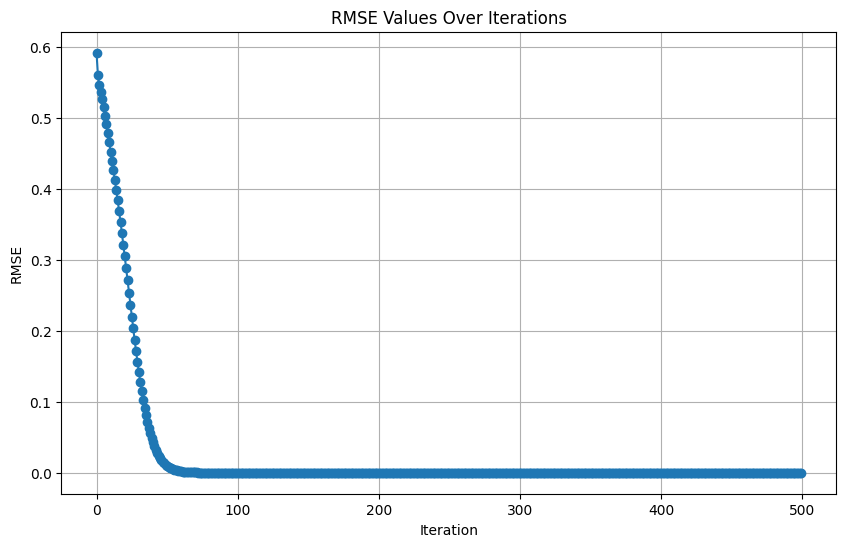

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(err_arr, marker='o', linestyle='-')
plt.title('RMSE Values Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()

In [17]:
#LFG! IT WORKS!

#now trying XOR with Xavier Init

In [19]:
w, b = w_init_tanh([2,5,1])
iterations = len(in_data[0])
n_layers = 3

In [20]:
err_arr = []
for i in range(500):
  learn(in_data,out_data, w ,b, parameters)
  predicted = []
  for data in zip(*in_data):
      pred = predict(np.array(data), w, b, n_layers)
      predicted.append(pred)

  predicted = np.array(predicted)
  rmse = rms_error(out_data, predicted)
  err_arr.append(rmse)

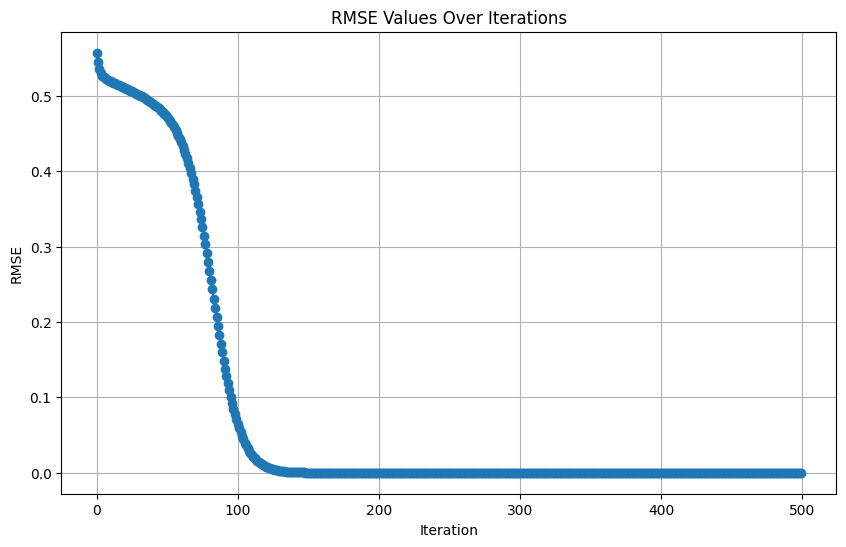

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(err_arr, marker='o', linestyle='-')
plt.title('RMSE Values Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()

In [ ]:
#LLLFFFGGGGGGGG!!